In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
!pip install flwr scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.12.3
    Uninstalling typer-0.12.3:
      Successfully uninstalled typer-0.12.3
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


In [ ]:
!mkdir -p /content/gdrive/MyDrive/federated_learning/

In [3]:
 pip install -U flwr["simulation"]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 35.4 MB/s eta 0:00:00


In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings
os.environ['RAY_DEDUP_LOGS'] = '0'  # Disable Ray log deduplication


In [ ]:
!pip install --upgrade flwr

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


def load_data(paths):
  data = pd.concat([pd.read_csv(path) for path in paths])
  return data

def split_features_labels(data):
  print("split_features")
  X = data.drop(columns=['type'])
  y = data['type']
  return X,y

def balance_data(X_train, y_train):
    over = SMOTE(sampling_strategy=0.8, random_state=42)
    X_res, y_res = over.fit_resample(X_train, y_train)
    return X_res, y_res

def sampling(X, y):
    print("Sampling data...")
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_index, test_index = next(sss.split(X, y))
    scaler = MinMaxScaler()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train_balanced, y_train_balanced = balance_data(X_train, y_train)
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)
    #print(y_train_balanced.value_counts())
    return X_train_scaled, X_test_scaled, y_train_balanced, y_test


def startified_sampling(X, y):
    print("Sampling data...")
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    train_index, test_index = next(sss.split(X, y))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return X_train, X_test, y_train, y_test


def create_model():

    #best_svc_params, best_lr_params, best_rf_params = hyperparameter_tuning(X_train, y_train)

    estimators = [('SVM model', LinearSVC(random_state=42, max_iter=10000, class_weight='balanced', dual='auto')),
                  ('logistic regression', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))]

    stacking = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier())
    print("model created")

    return stacking

def get_model_params(model):
  params = []
    # Extract parameters from base models
  for estimator in model.estimators_:
        if hasattr(estimator, 'coef_'):
            params.append(estimator.coef_.tolist())
            params.append(estimator.intercept_.tolist())
        elif hasattr(estimator, 'feature_importances_'):
            params.append(estimator.feature_importances_.tolist())


    # Extract parameters from the meta-model
  meta_model = model.final_estimator_
  if hasattr(meta_model, 'feature_importances_'):
        params.append(meta_model.feature_importances_.tolist())
  """if hasattr(meta_model, 'min_samples_split'):
        params.append([meta_model.min_samples_split])"""
  if hasattr(meta_model, 'n_estimators'):
        params.append([meta_model.n_estimators])

  #print(params)

  return params

def set_model_params(model, parameters):
  i = 0
    # Set parameters for base models
  for estimator in model.estimators_:
        if hasattr(estimator, 'coef_'):
            estimator.coef_ = np.array(parameters[i])
            estimator.intercept_ = np.array(parameters[i + 1])
            i += 2
        elif hasattr(estimator, 'feature_importances_'):
            estimator.feature_importances_ = np.array(parameters[i])
            i += 1

    # Set parameters for themeta-model
  meta_model = model.final_estimator
  if hasattr(meta_model, 'feature_importances_'):
        meta_model.feature_importances_ = np.array(parameters[i])
        i += 1
  """if hasattr(meta_model, 'min_samples_split'):
        meta_model.min_samples_split = int(parameters[i])
        i += 1"""
  if hasattr(meta_model, 'n_estimators_'):
        meta_model.n_estimators = int(parameters[i])
        i += 1

  #print(parameters)



In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def load_data(paths):
  data = pd.concat([pd.read_csv(path) for path in paths])
  return data

data = load_data([
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/1_cleaned_dataset.csv',
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/2_cleaned_dataset.csv',
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/3_cleaned_dataset.csv',
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/4_cleaned_dataset.csv',
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/5_cleaned_dataset.csv',
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/6_cleaned_dataset.csv',
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/7_cleaned_dataset.csv',
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/8_cleaned_dataset.csv',
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/9_cleaned_dataset.csv'
    ])

X , y = split_features_labels(data)
X_client, X_server, y_client, y_server = sampling(X, y)
print(X_client.shape)
print(X_server.shape)
print(y_client.shape)
print(y_server.shape)

X_server = pd.DataFrame(X_server)
y_server = pd.Series(y_server)


X_server_train, X_server_test, y_server_train, y_server_test = startified_sampling(X_server, y_server)
print(X_server_train.shape)
print(X_server_test.shape)
print(y_server_train.shape)
print(y_server_test.shape)
print("server co-ordinates")
print(X_server_train.shape)
print(X_server_test.shape)
print(y_server_train.shape)
print(y_server_test.shape)

print(X_server_train, X_server_test, y_server_train, y_server_test)

client_data = np.array_split(X_client, 6)
client_labels = np.array_split(y_client, 6)

client_train_test_data = []

for data, labels in zip(client_data, client_labels):
    data = pd.DataFrame(data)
    labels = pd.Series(labels)
    X_train, X_test, y_train, y_test = startified_sampling(data, labels)
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    print("client co-ordinates")
    print(X_train, X_test, y_train, y_test)
    client_train_test_data.append((X_train, X_test, y_train, y_test))
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)



X_clients_test = np.concatenate([X_test for _, X_test, _, _ in client_train_test_data])
y_clients_test = np.concatenate([y_test for _, _, _, y_test in client_train_test_data])

print("clients testing values")
print(X_clients_test.shape)
print(y_clients_test.shape)





split_features
Sampling data...
(980727, 115)
(980728, 115)
(980727,)
(980728,)
(686509, 115)
(294219, 115)
(686509,)
(294219,)
server co-ordinates
(686509, 115)
(294219, 115)
(686509,)
(294219,)
             0             1             2         3             4    \
436414  0.150436  3.921359e-05  2.072080e-06  0.158007  7.483512e-05   
701284  0.377793  7.214112e-03  8.077222e-05  0.441762  7.633710e-03   
766763  0.233784  3.192723e-01  5.549985e-02  0.328804  2.884401e-01   
838933  0.205671  3.113291e-07  1.722046e-08  0.190121  4.762498e-06   
25815   0.304987  1.752421e-01  1.237529e-01  0.363697  1.899775e-01   
...          ...           ...           ...       ...           ...   
253784  0.257880  6.046172e-03  9.950385e-05  0.274678  5.507848e-03   
471538  0.000000  4.857226e-17  0.000000e+00  0.000000  5.551115e-17   
728855  0.291572  8.737432e-03  4.533792e-05  0.409971  8.162603e-03   
849578  0.000000  4.857226e-17  0.000000e+00  0.000000  5.551115e-17   
417925  0.00

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


(114418, 115)
(49037, 115)
(114418,)
(49037,)
client co-ordinates
             0             1             2         3             4    \
121519  0.000000  4.857226e-17  0.000000e+00  0.000000  5.551115e-17   
159585  0.494332  6.536254e-03  9.065572e-05  0.582465  7.095135e-03   
159532  0.321797  8.188879e-03  6.020668e-05  0.397100  8.572402e-03   
12909   0.387348  1.040836e-01  1.064221e-01  0.445774  1.474798e-01   
45278   0.000004  4.327679e-03  8.676115e-07  0.000042  4.555794e-03   
...          ...           ...           ...       ...           ...   
33569   0.553033  8.643596e-03  4.804966e-05  0.743696  8.436514e-03   
40172   0.673117  6.384162e-03  9.237549e-05  0.817713  7.104918e-03   
228     0.000000  4.857226e-17  0.000000e+00  0.000000  5.551115e-17   
10739   0.279257  9.986269e-03  2.635519e-06  0.364523  1.001830e-02   
46015   0.227047  2.455656e-01  1.056160e-01  0.280613  2.578994e-01   

             5         6             7         8         9    ...    

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


def evaluate_global_model(global_model, X_server_test, y_server_test, X_clients_test, y_clients_test):

      combined_X_test = np.concatenate([X_server_test, X_clients_test])
      combined_y_test = np.concatenate([y_server_test, y_clients_test])
      #combined_y_test = combined_y_test.reshape(-1)

      y_true =[]
      y_pred =[]
      y_score = []


      y_pred = global_model.predict(combined_X_test)
      y_true = combined_y_test
      y_score = global_model.predict_proba(combined_X_test)[:, 1]

      cm = confusion_matrix(y_true, y_pred)
      tn, fp, fn, tp = cm.ravel()

      accuracy = (accuracy_score(y_true, y_pred)*100)
      report = classification_report(y_true, y_pred)
      fpr, tpr, _ = roc_curve(y_true, y_score)
      roc_auc = auc(fpr, tpr)

      print("Classification Report:")
      print(report)
      print("Confusion Matrix:")
      print(cm)


      #plotting curve
      plt.figure()
      plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
      plt.plot([0,1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic')
      plt.legend(loc="lower right")
      plt.show()

      np.save('/content/gdrive/MyDrive/N-BaIoT/stacking_accuracy.npy',accuracy)
      np.save('/content/gdrive/MyDrive/N-BaIoT/stacking_report.npy',report)
      np.save('/content/gdrive/MyDrive/N-BaIoT/stacking_cm.npy',cm)
      np.save('/content/gdrive/MyDrive/N-BaIoT/stacking_roc_auc.npy',roc_auc)

      return accuracy, report, cm, roc_auc

In [15]:
import flwr as fl
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
from flwr.common import Context
#from Utils import create_model, get_model_params, set_model_params, sampling, load_data, split_features_labels

class IoTClient(fl.client.NumPyClient):
    def __init__(self, cid, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.cid = cid
        self.train_data = X_train
        self.test_data = X_test
        self.train_labels = y_train
        self.test_labels = y_test
        print(f"Entered client {cid} function")
        self.model.fit(self.train_data, self.train_labels)

    def get_parameters(self, config=None):
        return get_model_params(self.model)

    def fit(self, parameters, config):
        print("training model")
        set_model_params(self.model, parameters)
        self.model.fit(self.train_data, self.train_labels)
        return get_model_params(self.model), len(self.train_labels),{}

    def evaluate(self, parameters, config):
        print(f"Evaluating model for client {self.cid}")
        set_model_params(self.model, parameters)
        y_pred = self.model.predict(self.test_data)
        loss = log_loss(self.test_labels, y_pred)
        accuracy = accuracy_score(self.test_labels, y_pred)
        print("Loss:", loss)
        print("Accuracy:", accuracy*100)
        return float(loss), len(self.test_labels), {"loss": float(loss), "accuracy": float(accuracy)}

def client_fn(cid : str) -> fl.client.Client:

  cid = int(cid)
  print(f"Entered client {cid} function")
  model = create_model()
  X_train, X_test, y_train, y_test = client_train_test_data[cid]
  #if len(np.unique(y_train))>1:
  return IoTClient(cid, model, X_train, X_test, y_train, y_test).to_client()



In [12]:
global_model = create_model()
start_time = time.time()
global_model.fit(X_server_train, y_server_train)

model created


StackingClassifier(estimators=[('SVM model',
                                LinearSVC(class_weight='balanced', dual='auto',
                                          max_iter=10000, random_state=42)),
                               ('logistic regression',
                                LogisticRegression(class_weight='balanced',
                                                   max_iter=1000,
                                                   random_state=42))],
                   final_estimator=RandomForestClassifier())

In [13]:
import flwr as fl
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
#from Utils import load_data, split_features_labels, sampling, create_model, get_model_params
#from Client import client_fn
from typing import Callable, Dict, List, Tuple
import torch
from flwr.common import Parameters, NDArrays
import random
from sklearn.metrics import accuracy_score, log_loss
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
import time

def fit_round(rnd: int):
    return {"num_clients": 3}

def evaluate_round(rnd: int):
    return {"num_clients": 3}

def get_on_fit_config_fn() -> Callable[[int], Dict[str, str]]:
  def fit_config(server_rnd: int) -> Dict[str, str]:
    config = {
      "learning_rate": str(0.001 * (0.9 ** server_rnd)),
      "batch_size": str(32 * (0.9 ** server_rnd)),
      "epochs": str(1)
    }
    return config
  return fit_config



def calculate_federated_learning_time(start_time, end_time):

  total_time = end_time - start_time
  return total_time




def get_evaluate_fn(model, X_server_test, y_server_test, X_clients_test, y_clients_test):
  def evaluate(server_round: int, parameters: Parameters, config: Dict[str, str]) -> Tuple[float, Dict[str, float]]:
    if server_round < 5:
            return 0.0, {"loss": 0.0, "accuracy": 0.0}
      #y_pred = model.predict(X_test_global)
    elif server_round == 5:
        set_model_params(model, parameters)
        accuracy, report, cm, roc_auc = evaluate_global_model(model, X_server_test, y_server_test, X_clients_test, y_clients_test)
        #accuracy = accuracy_score(final_y_test, model.predict(final_X_test))
    return 0.0, {"accuracy": accuracy, "loss": 0.0, "report": report, "confusion_matrix": cm, "roc_auc": roc_auc}
  return evaluate





def start_server():


    initial_parameters = get_model_params(global_model)


    strategy = fl.server.strategy.FedAvg(
        #num_clients=3,
        fraction_fit=0.5,
        min_fit_clients=3,
        min_available_clients =6,
        min_evaluate_clients=3,
        fraction_evaluate=0.5,
        on_fit_config_fn=get_on_fit_config_fn(),
        evaluate_fn=get_evaluate_fn(global_model, X_server_test, y_server_test, X_clients_test, y_clients_test),
        initial_parameters=fl.common.ndarrays_to_parameters(initial_parameters)

    )


    fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=6,
        config=fl.server.ServerConfig(num_rounds=5),
        strategy=strategy,
        client_resources={"num_cpus": 1, "num_gpus": 0},
        ray_init_args={"ignore_reinit_error": True, "num_cpus": 6},
    )

end_time = time.time()
    #evaluate_fn=get_evaluate_fn(global_model, final_X_test, final_y_test, X_test_global, y_test_global),







INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-09 06:20:29,616	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 16959777177.0, 'node:__internal_head__': 1.0, 'accelerator_type:L4': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 6.0, 'memory': 33919554356.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 6 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Eva

(ClientAppActor pid=17220) Entered client 1 function
(ClientAppActor pid=17220) model created
(ClientAppActor pid=17220) Entered client 1 function
(ClientAppActor pid=17219) Entered client 4 function
(ClientAppActor pid=17219) model created
(ClientAppActor pid=17219) Entered client 4 function


(ClientAppActor pid=17220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17220) 
(ClientAppActor pid=17220)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17220)             entirely in future versions of Flower.
(ClientAppActor pid=17220)         
(ClientAppActor pid=17219) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17219) 
(ClientAppActor pid=17219)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17219)             entirely in future versions of Flower.
(ClientAppActor pid=1721

(ClientAppActor pid=17222) Entered client 5 function
(ClientAppActor pid=17222) model created
(ClientAppActor pid=17222) Entered client 5 function


(ClientAppActor pid=17222) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17222) 
(ClientAppActor pid=17222)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17222)             entirely in future versions of Flower.
(ClientAppActor pid=17222)         


(ClientAppActor pid=17220) training model
(ClientAppActor pid=17222) training model
(ClientAppActor pid=17219) training model


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (1, 0.0, {'loss': 0.0, 'accuracy': 0.0}, 65.73193402800007)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=17219) Entered client 3 function
(ClientAppActor pid=17219) model created
(ClientAppActor pid=17219) Entered client 3 function


(ClientAppActor pid=17219) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17219) 
(ClientAppActor pid=17219)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17219)             entirely in future versions of Flower.
(ClientAppActor pid=17219)         


(ClientAppActor pid=17220) Entered client 4 function
(ClientAppActor pid=17220) model created
(ClientAppActor pid=17220) Entered client 4 function


(ClientAppActor pid=17220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17220) 
(ClientAppActor pid=17220)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17220)             entirely in future versions of Flower.
(ClientAppActor pid=17220)         


(ClientAppActor pid=17222) Entered client 5 function
(ClientAppActor pid=17222) model created
(ClientAppActor pid=17222) Entered client 5 function


(ClientAppActor pid=17222) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17222) 
(ClientAppActor pid=17222)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17222)             entirely in future versions of Flower.
(ClientAppActor pid=17222)         


(ClientAppActor pid=17219) Evaluating model for client 3
(ClientAppActor pid=17222) Evaluating model for client 5
(ClientAppActor pid=17219) Loss: 0.014700594811720822
(ClientAppActor pid=17219) Accuracy: 99.95921447070579
(ClientAppActor pid=17222) Loss: 0.008085327146446553
(ClientAppActor pid=17222) Accuracy: 99.97756795888819


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]


(ClientAppActor pid=17220) Evaluating model for client 4


INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=17220) Loss: 0.01102544610879067
(ClientAppActor pid=17220) Accuracy: 99.96941085302934
(ClientAppActor pid=17220) Entered client 1 function
(ClientAppActor pid=17220) model created
(ClientAppActor pid=17220) Entered client 1 function


(ClientAppActor pid=17220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17220) 
(ClientAppActor pid=17220)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17220)             entirely in future versions of Flower.
(ClientAppActor pid=17220)         


(ClientAppActor pid=17222) Entered client 2 function
(ClientAppActor pid=17222) model created
(ClientAppActor pid=17222) Entered client 2 function


(ClientAppActor pid=17222) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17222) 
(ClientAppActor pid=17222)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17222)             entirely in future versions of Flower.
(ClientAppActor pid=17222)         


(ClientAppActor pid=17219) Entered client 0 function
(ClientAppActor pid=17219) model created
(ClientAppActor pid=17219) Entered client 0 function


(ClientAppActor pid=17219) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17219) 
(ClientAppActor pid=17219)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17219)             entirely in future versions of Flower.
(ClientAppActor pid=17219)         


(ClientAppActor pid=17220) training model
(ClientAppActor pid=17222) training model
(ClientAppActor pid=17219) training model


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (2, 0.0, {'loss': 0.0, 'accuracy': 0.0}, 166.79967224099983)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=17219) Entered client 0 function
(ClientAppActor pid=17219) model created
(ClientAppActor pid=17219) Entered client 0 function


(ClientAppActor pid=17219) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17219) 
(ClientAppActor pid=17219)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17219)             entirely in future versions of Flower.
(ClientAppActor pid=17219)         


(ClientAppActor pid=17222) Entered client 4 function
(ClientAppActor pid=17222) model created
(ClientAppActor pid=17222) Entered client 4 function


(ClientAppActor pid=17222) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17222) 
(ClientAppActor pid=17222)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17222)             entirely in future versions of Flower.
(ClientAppActor pid=17222)         


(ClientAppActor pid=17220) Entered client 5 function
(ClientAppActor pid=17220) model created
(ClientAppActor pid=17220) Entered client 5 function


(ClientAppActor pid=17220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17220) 
(ClientAppActor pid=17220)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17220)             entirely in future versions of Flower.
(ClientAppActor pid=17220)         


(ClientAppActor pid=17220) Evaluating model for client 5
(ClientAppActor pid=17220) Loss: 0.008085327146446553
(ClientAppActor pid=17220) Accuracy: 99.97756795888819
(ClientAppActor pid=17222) Evaluating model for client 4
(ClientAppActor pid=17222) Loss: 0.01102544610879067
(ClientAppActor pid=17222) Accuracy: 99.96941085302934


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=17219) Evaluating model for client 0
(ClientAppActor pid=17219) Loss: 0.0117604758493767
(ClientAppActor pid=17219) Accuracy: 99.96737157656463
(ClientAppActor pid=17219) Entered client 5 function
(ClientAppActor pid=17219) model created
(ClientAppActor pid=17219) Entered client 5 function


(ClientAppActor pid=17219) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17219) 
(ClientAppActor pid=17219)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17219)             entirely in future versions of Flower.
(ClientAppActor pid=17219)         


(ClientAppActor pid=17222) Entered client 2 function
(ClientAppActor pid=17222) model created
(ClientAppActor pid=17222) Entered client 2 function
(ClientAppActor pid=17220) Entered client 1 function
(ClientAppActor pid=17220) model created
(ClientAppActor pid=17220) Entered client 1 function


(ClientAppActor pid=17222) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17222) 
(ClientAppActor pid=17222)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17222)             entirely in future versions of Flower.
(ClientAppActor pid=17222)         
(ClientAppActor pid=17220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17220) 
(ClientAppActor pid=17220)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17220)             entirely in future versions of Flower.
(ClientAppActor pid=1722

(ClientAppActor pid=17220) training model
(ClientAppActor pid=17219) training model
(ClientAppActor pid=17222) training model


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (3, 0.0, {'loss': 0.0, 'accuracy': 0.0}, 268.23986786099977)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=17219) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17219) 
(ClientAppActor pid=17219)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17219)             entirely in future versions of Flower.
(ClientAppActor pid=17219)         
(ClientAppActor pid=17222) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`


(ClientAppActor pid=17219) Entered client 0 function
(ClientAppActor pid=17219) model created
(ClientAppActor pid=17219) Entered client 0 function
(ClientAppActor pid=17222) Entered client 2 function
(ClientAppActor pid=17222) model created
(ClientAppActor pid=17222) Entered client 2 function
(ClientAppActor pid=17220) Entered client 5 function
(ClientAppActor pid=17220) model created
(ClientAppActor pid=17220) Entered client 5 function


(ClientAppActor pid=17220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17220) 
(ClientAppActor pid=17220)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17220)             entirely in future versions of Flower.
(ClientAppActor pid=17220)         


(ClientAppActor pid=17220) Evaluating model for client 5
(ClientAppActor pid=17220) Loss: 0.008085327146446553
(ClientAppActor pid=17220) Accuracy: 99.97756795888819
(ClientAppActor pid=17222) Evaluating model for client 2
(ClientAppActor pid=17222) Loss: 0.010290416368204644
(ClientAppActor pid=17222) Accuracy: 99.97145012949406


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=17219) Evaluating model for client 0


(ClientAppActor pid=17219) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17219) 
(ClientAppActor pid=17219)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17219)             entirely in future versions of Flower.
(ClientAppActor pid=17219)         
(ClientAppActor pid=17222) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17222) 
(ClientAppActor pid=17222)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17222)             entirely in future versions of Flower.
(ClientAppActor pid=1722

(ClientAppActor pid=17219) Loss: 0.013965565071134792
(ClientAppActor pid=17219) Accuracy: 99.9612537471705
(ClientAppActor pid=17219) Entered client 3 function
(ClientAppActor pid=17219) model created
(ClientAppActor pid=17219) Entered client 3 function
(ClientAppActor pid=17222) Entered client 0 function
(ClientAppActor pid=17222) model created
(ClientAppActor pid=17222) Entered client 0 function


(ClientAppActor pid=17220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17220) 
(ClientAppActor pid=17220)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17220)             entirely in future versions of Flower.
(ClientAppActor pid=17220)         


(ClientAppActor pid=17220) Entered client 2 function
(ClientAppActor pid=17220) model created
(ClientAppActor pid=17220) Entered client 2 function
(ClientAppActor pid=17219) training model
(ClientAppActor pid=17220) training model
(ClientAppActor pid=17222) training model


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (4, 0.0, {'loss': 0.0, 'accuracy': 0.0}, 374.02665414800003)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=17222) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17222) 
(ClientAppActor pid=17222)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17222)             entirely in future versions of Flower.
(ClientAppActor pid=17222)         


(ClientAppActor pid=17222) Entered client 4 function
(ClientAppActor pid=17222) model created
(ClientAppActor pid=17222) Entered client 4 function
(ClientAppActor pid=17220) Entered client 3 function
(ClientAppActor pid=17220) model created
(ClientAppActor pid=17220) Entered client 3 function


(ClientAppActor pid=17220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17220) 
(ClientAppActor pid=17220)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17220)             entirely in future versions of Flower.
(ClientAppActor pid=17220)         
(ClientAppActor pid=17219) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17219) 
(ClientAppActor pid=17219)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17219)             entirely in future versions of Flower.
(ClientAppActor pid=1721

(ClientAppActor pid=17219) Entered client 2 function
(ClientAppActor pid=17219) model created
(ClientAppActor pid=17219) Entered client 2 function
(ClientAppActor pid=17220) Evaluating model for client 3
(ClientAppActor pid=17220) Loss: 0.01617065429289288
(ClientAppActor pid=17220) Accuracy: 99.95513591777637
(ClientAppActor pid=17222) Evaluating model for client 4
(ClientAppActor pid=17222) Loss: 0.01102544610879067
(ClientAppActor pid=17222) Accuracy: 99.96941085302934
(ClientAppActor pid=17219) Evaluating model for client 2


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=17219) Loss: 0.006615267665274492
(ClientAppActor pid=17219) Accuracy: 99.98164651181762
(ClientAppActor pid=17219) Entered client 0 function
(ClientAppActor pid=17219) model created
(ClientAppActor pid=17219) Entered client 0 function
(ClientAppActor pid=17220) Entered client 4 function
(ClientAppActor pid=17220) model created
(ClientAppActor pid=17220) Entered client 4 function
(ClientAppActor pid=17222) Entered client 5 function
(ClientAppActor pid=17222) model created
(ClientAppActor pid=17222) Entered client 5 function


(ClientAppActor pid=17219) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17219) 
(ClientAppActor pid=17219)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17219)             entirely in future versions of Flower.
(ClientAppActor pid=17219)         
(ClientAppActor pid=17220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17220) 
(ClientAppActor pid=17220)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17220)             entirely in future versions of Flower.
(ClientAppActor pid=1722

(ClientAppActor pid=17222) training model
(ClientAppActor pid=17220) training model
(ClientAppActor pid=17219) training model


INFO :      aggregate_fit: received 3 results and 0 failures


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41092
           1       1.00      1.00      1.00    547349

    accuracy                           1.00    588441
   macro avg       1.00      1.00      1.00    588441
weighted avg       1.00      1.00      1.00    588441

Confusion Matrix:
[[ 40997     95]
 [   114 547235]]


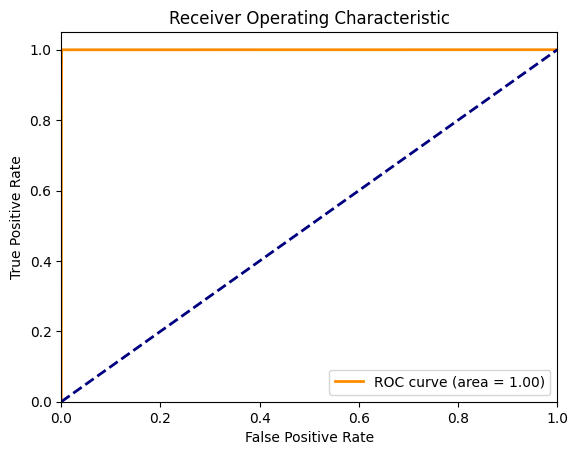

INFO :      fit progress: (5, 0.0, {'accuracy': 99.96448242049755, 'loss': 0.0, 'report': '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     41092\n           1       1.00      1.00      1.00    547349\n\n    accuracy                           1.00    588441\n   macro avg       1.00      1.00      1.00    588441\nweighted avg       1.00      1.00      1.00    588441\n', 'confusion_matrix': array([[ 40997,     95],
       [   114, 547235]]), 'roc_auc': 0.9998582305718723}, 487.4146278999997)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=17219) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17219) 
(ClientAppActor pid=17219)             This is a deprecated feature. It wil

(ClientAppActor pid=17219) Entered client 1 function
(ClientAppActor pid=17219) model created
(ClientAppActor pid=17219) Entered client 1 function
(ClientAppActor pid=17220) Entered client 0 function
(ClientAppActor pid=17220) model created
(ClientAppActor pid=17220) Entered client 0 function
(ClientAppActor pid=17222) Entered client 3 function
(ClientAppActor pid=17222) model created
(ClientAppActor pid=17222) Entered client 3 function


(ClientAppActor pid=17222) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=17222) 
(ClientAppActor pid=17222)             This is a deprecated feature. It will be removed
(ClientAppActor pid=17222)             entirely in future versions of Flower.
(ClientAppActor pid=17222)         


(ClientAppActor pid=17222) Evaluating model for client 3
(ClientAppActor pid=17219) Evaluating model for client 1
(ClientAppActor pid=17222) Loss: 0.014700594811720822
(ClientAppActor pid=17222) Accuracy: 99.95921447070579
(ClientAppActor pid=17219) Loss: 0.013230535330548762
(ClientAppActor pid=17219) Accuracy: 99.96329302363522


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 524.28s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.011270456022319348
INFO :      		round 2: 0.01029041636820464
INFO :      		round 3: 0.010780436195261997
INFO :      		round 4: 0.011270456022319348
INFO :      		round 5: 0.013965565071134793
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0
INFO :      		round 1: 0.0
INFO :      		round 2: 0.0
INFO :      		round 3: 0.0
INFO :      		round 4: 0.0
INFO :      		round 5: 0.0
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.0),
INFO :      	              (1, 0.0),
INFO :      	              (2, 0.0),
INFO :      	              (3, 0.0),
INFO :      	              (4, 0.0),
INFO :      	              (5, 99.96448242049755)],
INFO :      	 'confusion_matrix': [(5, array([[ 40997,     95],
INFO :      	       [   114, 547235]]))],

(ClientAppActor pid=17220) Evaluating model for client 0


INFO :      	             '   macro avg       1.00      1.00      1.00    588441\n'
INFO :      	             'weighted avg       1.00      1.00      1.00    588441\n')],
INFO :      	 'roc_auc': [(5, 0.9998582305718723)]}
INFO :      


(ClientAppActor pid=17220) Loss: 0.013965565071134792
(ClientAppActor pid=17220) Accuracy: 99.9612537471705
Total time taken: 229.6752142906189 seconds


In [16]:
if __name__ == "__main__":
    start_server()
    total_time = calculate_federated_learning_time(start_time, end_time)
    print("Total time taken:", total_time, "seconds")